<a href="https://colab.research.google.com/github/AgniKoko/DIP_HW02/blob/main/DIP_HW02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Κοκορότσικου Αγνή Ιωάννα, 58767
[GitHub repository](https://github.com/AgniKoko/DIP_HW02)

# Step 1

**Άσκηση 5 - Τεχνικές Συμπίεσης εικόνας**

Χρήσιμες Βιβλιοθήκες:
* Documentation OpenCV:      https://docs.opencv.org/4.x/index.html
* Documentation SciPy:       https://docs.scipy.org/doc/scipy/
* Documentation skimage:     https://scikit-image.org/docs/stable/api/api.html
* Documentation Matlplotlib: https://matplotlib.org/stable/index.html


In [76]:
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from skimage.util import view_as_blocks
import heapq
from collections import defaultdict
import urllib.request

image = cv2.imread('dog_square.png')
ycbcr_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
Y, Cb, Cr = cv2.split(ycbcr_image)

# Calculating the size in bytes of orignal image
B, G, R = cv2.split(image)
image_size_bytes = B.nbytes + G.nbytes + R.nbytes


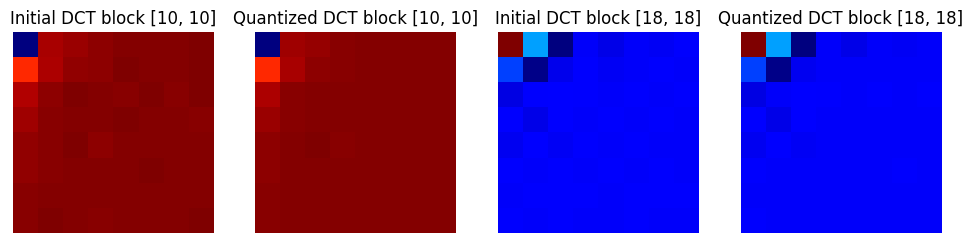

In [77]:
# Function to compute the 2D DCT of an 8x8 block
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

# Process each channel with block-wise DCT and quantization
def process_channel(channel):
    blocks = view_as_blocks(channel, block_shape=(8, 8))
    dct_blocks = np.zeros_like(blocks)
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            block = blocks[i, j]
            dct_blocks[i, j] = dct2(block - 128)
    return dct_blocks

Y_processed = process_channel(Y.astype(int))
Cb_processed = process_channel(Cb.astype(int))
Cr_processed = process_channel(Cr.astype(int))

Y_blocks = view_as_blocks(Y.astype(int), block_shape=(8, 8))

plt.figure(figsize=(12, 12))
plt.subplot(4, 4, 1)
plt.imshow(dct2(Y_blocks[10, 10]-128), cmap='jet')
plt.title('Initial DCT block [10, 10]')
plt.axis('off')
plt.subplot(4, 4, 2)
plt.imshow(Y_processed[10, 10], cmap='jet')
plt.title('Quantized DCT block [10, 10]')
plt.axis('off')
plt.subplot(4, 4, 3)
plt.imshow(dct2(Y_blocks[18, 18]-128), cmap='jet')
plt.title('Initial DCT block [18, 18]')
plt.axis('off')
plt.subplot(4, 4, 4)
plt.imshow(Y_processed[18, 18], cmap='jet')
plt.title('Quantized DCT block [18, 18]')
plt.axis('off')
plt.show()

In [78]:
# nb, mb = Y_processed.shape[:2]
#                   ?????????????????????????????????????????????????????????????
# dc_values = np.zeros((nb, mb))

def dc_values_compute(channel):
  nb, mb = Y_processed.shape[:2]
  dc_values = np.zeros((nb, mb))
  for i in range(channel.shape[0]):
      for j in range(channel.shape[1]):
        coeffs = channel[i, j]
        dc_values[i, j] = coeffs[0, 0]
  return dc_values

Y_dc_values = dc_values_compute(Y_processed)
Cb_dc_values = dc_values_compute(Cb_processed)
Cr_dc_values = dc_values_compute(Cr_processed)

combined_dc_values = np.dstack((Y_dc_values, Cb_dc_values, Cr_dc_values))

print(combined_dc_values.shape)
print(combined_dc_values[:10,:10, 0])

(64, 64, 3)
[[-554. -574. -606. -637. -643. -650. -656. -657. -640. -629.]
 [-438. -488. -531. -560. -581. -585. -592. -613. -628. -629.]
 [-352. -391. -430. -462. -473. -484. -505. -530. -563. -585.]
 [-274. -291. -322. -304. -298. -350. -398. -428. -464. -480.]
 [ -91. -109. -139. -102. -112. -180. -286. -336. -360. -354.]
 [ -20.    2.  -23.  -22.  -42.  -86. -158. -195. -214. -233.]
 [  17.   48.  -20.   -8.   -7.  -39.  -81. -105. -136. -163.]
 [  25.   40.  -21.  -66.  -72.  -69.  -44.  -56. -122. -177.]
 [ -46.  -16.   -8.  -69. -101. -108.  -93. -124. -188. -235.]
 [ -94.  -54.  -61. -124. -160. -132. -130. -176. -239. -284.]]


**Διαφορική Κωδικοποίηση**

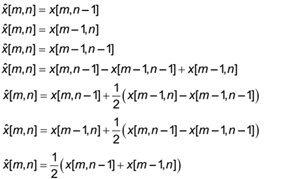

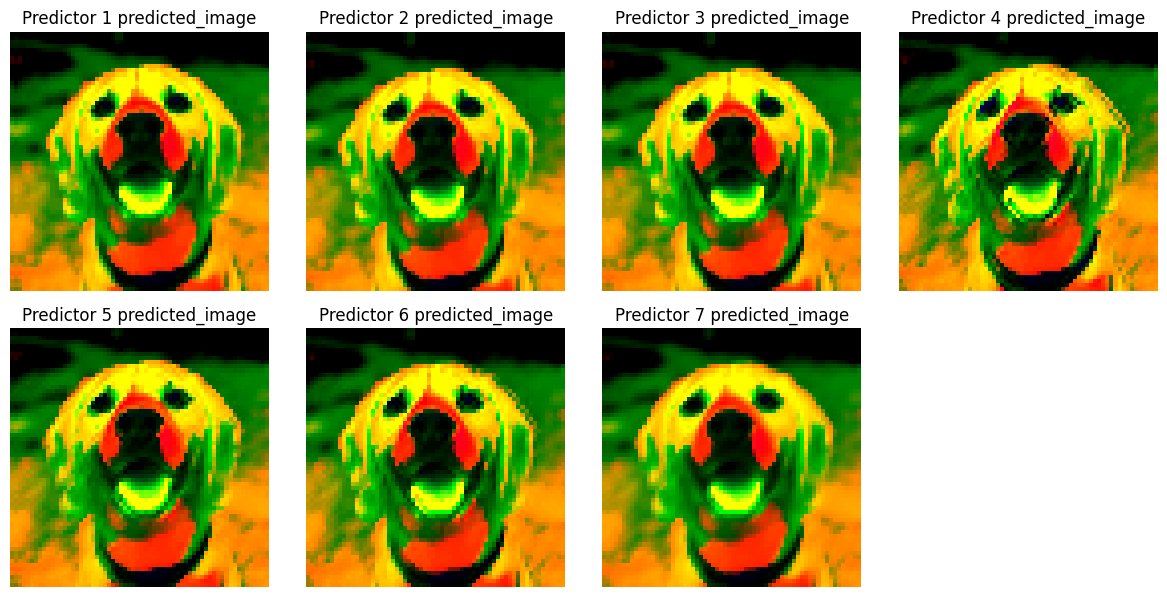

In [79]:
predictor1_mask = np.array([[0, 0, 0], [1, 0, 0], [0, 0, 0]])
predictor2_mask = np.array([[0, 1, 0], [0, 0, 0], [0, 0, 0]])
predictor3_mask = np.array([[1, 0, 0], [0, 0, 0], [0, 0, 0]])
predictor4_mask = predictor1_mask - predictor3_mask + predictor2_mask
predictor5_mask = predictor1_mask + 0.5 * (predictor2_mask - predictor3_mask)
predictor6_mask = predictor2_mask + 0.5 * (predictor1_mask - predictor3_mask)
predictor7_mask = 0.5 * (predictor1_mask + predictor2_mask)

# Apply predictors as filters
predicted_image_1 = cv2.filter2D(combined_dc_values, -1, predictor1_mask)
predicted_image_2 = cv2.filter2D(combined_dc_values, -1, predictor2_mask)
predicted_image_3 = cv2.filter2D(combined_dc_values, -1, predictor3_mask)
predicted_image_4 = cv2.filter2D(combined_dc_values, -1, predictor4_mask)
predicted_image_5 = cv2.filter2D(combined_dc_values, -1, predictor5_mask)
predicted_image_6 = cv2.filter2D(combined_dc_values, -1, predictor6_mask)
predicted_image_7 = cv2.filter2D(combined_dc_values, -1, predictor7_mask)

predicted_images = [
    predicted_image_1,
    predicted_image_2,
    predicted_image_3,
    predicted_image_4,
    predicted_image_5,
    predicted_image_6,
    predicted_image_7
]

plt.figure(figsize=(12, 12))
for i, predicted_image in enumerate(predicted_images, start=1):
    plt.subplot(4, 4, i)
    plt.imshow(predicted_image.astype(int), cmap='gray')
    plt.title(f"Predictor {i} predicted_image")
    plt.axis('off')
plt.tight_layout()
plt.show()

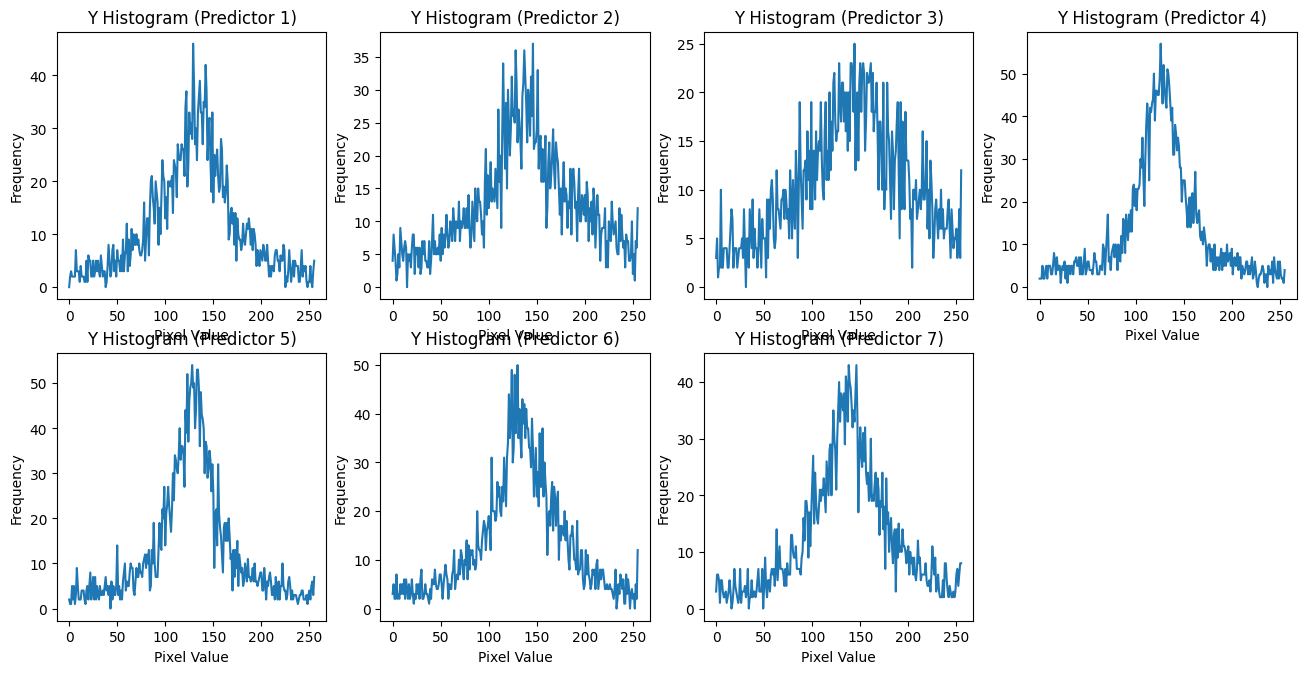

In [71]:
# Compute prediction errors for each predictor
prediction_error_1 = combined_dc_values.astype(int) - predicted_image_1.astype(int) # int ---> Epeidh einai unit8, gia na mhn kanei clip sto 0
prediction_error_2 = combined_dc_values.astype(int) - predicted_image_2.astype(int)
prediction_error_3 = combined_dc_values.astype(int) - predicted_image_3.astype(int)
prediction_error_4 = combined_dc_values.astype(int) - predicted_image_4.astype(int)
prediction_error_5 = combined_dc_values.astype(int) - predicted_image_5.astype(int)
prediction_error_6 = combined_dc_values.astype(int) - predicted_image_6.astype(int)
prediction_error_7 = combined_dc_values.astype(int) - predicted_image_7.astype(int)

prediction_errors = [
    prediction_error_1,
    prediction_error_2,
    prediction_error_3,
    prediction_error_4,
    prediction_error_5,
    prediction_error_6,
    prediction_error_7
]

Y_histogram_original,_ = np.histogram(image.flatten(), bins=256, range=(0, 255))
Cb_histogram_original,_ = np.histogram(combined_dc_values[:,:,1].flatten(), bins=256, range=(0, 255))
Cr_histogram_original,_ = np.histogram(combined_dc_values[:,:,2].flatten(), bins=256, range=(0, 255))

Y_histograms  = []
Cb_histograms = []
Cr_histograms = []
for i in range(7):
    Y_histogram, _ = np.histogram(prediction_errors[i][:,:,0].flatten(), bins=256, range=(-128, 128))
    Cb_histogram, _ = np.histogram(prediction_errors[i][:,:,1].flatten(), bins=256, range=(-128, 128))
    Cr_histogram, _ = np.histogram(prediction_errors[i][:,:,2].flatten(), bins=256, range=(-128, 128))
    Y_histograms.append(Y_histogram)
    Cb_histograms.append(Cb_histogram)
    Cr_histograms.append(Cr_histogram)

plt.figure(figsize=(16, 16))
for i, histogram in enumerate(Y_histograms, start=1):
    plt.subplot(4, 4, i)
    plt.plot(histogram)
    plt.title(f"Y Histogram (Predictor {i})")
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
plt.show()

In [72]:
def compute_entropy(histogram):
    histogram_normalized = histogram / histogram.sum()
    entropy_value = -np.sum(histogram_normalized * np.log2(histogram_normalized + 1e-10))
    return entropy_value

Y_entropies = []
Cb_entropies = []
Cr_entropies = []

Y_entropies  = [compute_entropy(h) for h in Y_histograms]
Cb_entropies = [compute_entropy(h) for h in Cb_histograms]
Cr_entropies = [compute_entropy(h) for h in Cr_histograms]

entropies = []
for i in range(7):
    entropies.append((Y_entropies[i] + Cb_entropies[i] + Cr_entropies[i]))
    print(f"Entropy for Predictor {i+1}: {entropies[i]}")

min_entropy = min(entropies)
min_idx = entropies.index(min_entropy) + 1
print()
print(f"Least entropy is entropy {min_idx} = {min_entropy}")
min_prediction_error = prediction_errors[min_idx]

Entropy for Predictor 1: 19.937600236572443
Entropy for Predictor 2: 20.329066379303605
Entropy for Predictor 3: 21.188896180213515
Entropy for Predictor 4: 19.054950781561818
Entropy for Predictor 5: 19.065031950982323
Entropy for Predictor 6: 19.351774226350123
Entropy for Predictor 7: 19.618496616473504

Least entropy is entropy 4 = 19.054950781561818


In [80]:
# Huffman coding
class HuffmanNode:
    def __init__(self, value, frequency):
        self.value = value
        self.frequency = frequency
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.frequency < other.frequency

def build_huffman_tree(frequencies):
    heap = [HuffmanNode(value, freq) for value, freq in frequencies.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(None, node1.frequency + node2.frequency)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)
    return heap[0]

def build_huffman_codes(tree, prefix="", codebook={}):
    if tree.value is not None:
        codebook[tree.value] = prefix
    else:
        if tree.left:
            build_huffman_codes(tree.left, prefix + "0", codebook)
        if tree.right:
            build_huffman_codes(tree.right, prefix + "1", codebook)
    return codebook

def huffman_encode(data):
    frequencies = defaultdict(int)
    for item in data:
        frequencies[item] += 1
    huffman_tree = build_huffman_tree(frequencies)
    huffman_codes = build_huffman_codes(huffman_tree)
    encoded_data = ''.join([huffman_codes[item] for item in data])
    return encoded_data, huffman_codes

In [81]:
Y_flattened = (min_prediction_error[:,:,0]).flatten()
Cb_flattened = (min_prediction_error[:,:,1]).flatten()
Cr_flattened = (min_prediction_error[:,:,2]).flatten()

encoded_Y_dc, huffman_codes_Y_dc = huffman_encode(Y_flattened)
encoded_Cb_dc, huffman_codes_Cb_dc = huffman_encode(Cb_flattened)
encoded_Cr_dc, huffman_codes_Cr_dc = huffman_encode(Cr_flattened)

encoded_dc_bit_stream = encoded_Y_dc + encoded_Cb_dc + encoded_Cr_dc

# Display the first 100 bits of the final bit stream for brevity
print(f"Encoded Bit Stream (first 100 bits): {encoded_dc_bit_stream[:100]}")

compressed_size = len(encoded_dc_bit_stream)
print(f"Compressed Size: {compressed_size} bits")

                                      # Στο compressed size συμπεριλαμβανουμε και τα bits για το καθε συμβολο



Encoded Bit Stream (first 100 bits): 0011100100101011100101010111110100011101111011111111011101011111010011110110010110110110111111011101
Compressed Size: 82746 bits


# Step 2

**Κωδικοποίηση Εντροπίας των κβαντισμένων συντελεστών**

Εκτελέστε τον ακόλουθο κώδικα που υλοποιήσει συμπίεση Huffman στα κβαντισμένα DCT blocks.
1. Συμπληρώστε τον κώδικα ώστε να υπολογίσετε τον λόγο συμπίεσης που επιτυγχάνεται.
2. Προβάλετε και παρατηρείστε τους κώδικες Huffman που δημιουργούνται.

In [82]:
# Zigzag order                            # Ξεδιπλωμα σειρας των block
zigzag_index = np.array([
    [0, 1, 5, 6, 14, 15, 27, 28],
    [2, 4, 7, 13, 16, 26, 29, 42],
    [3, 8, 12, 17, 25, 30, 41, 43],
    [9, 11, 18, 24, 31, 40, 44, 53],
    [10, 19, 23, 32, 39, 45, 52, 54],
    [20, 22, 33, 38, 46, 51, 55, 60],
    [21, 34, 37, 47, 50, 56, 59, 61],
    [35, 36, 48, 49, 57, 58, 62, 63]
])

def zigzag_scan(block):
    return block.flatten()[zigzag_index.flatten()]

Y_zigzag = [zigzag_scan(block) for block in Y_processed.reshape(-1, 8, 8)]
Cb_zigzag = [zigzag_scan(block) for block in Cr_processed.reshape(-1, 8, 8)]
Cr_zigzag = [zigzag_scan(block) for block in Cb_processed.reshape(-1, 8, 8)]

Y_flattened = np.concatenate(Y_zigzag).astype(int)
Cb_flattened = np.concatenate(Cb_zigzag).astype(int)
Cr_flattened = np.concatenate(Cr_zigzag).astype(int)

# Πρεπει να αφαιρεσουμε τους DC συντελεστες διοτι ακολουθουν διαφορετικη διαδικασια
def compute_non_dc_values(flat_channel):
  idx = np.arange(63, flat_channel.size, 64)
  non_dc_values = np.delete(flat_channel, idx)
  return non_dc_values

Y_non_dc = compute_non_dc_values(Y_flattened)
Cb_non_dc = compute_non_dc_values(Cb_flattened)
Cr_non_dc = compute_non_dc_values(Cr_flattened)

encoded_Y, huffman_codes_Y = huffman_encode(Y_non_dc)
encoded_Cb, huffman_codes_Cb = huffman_encode(Cb_non_dc)
encoded_Cr, huffman_codes_Cr = huffman_encode(Cr_non_dc)

encoded_bit_stream = encoded_Y + encoded_Cb + encoded_Cr
print(f"Encoded Bit Stream (first 100 bits): {encoded_bit_stream[:100]}")
compressed_size = len(encoded_bit_stream)
print(f"Compressed Size: {compressed_size} bits")

Encoded Bit Stream (first 100 bits): 0110101101100101100101111111111111011111110110111001010111111100000010110011000000111111111111110111
Compressed Size: 1589747 bits


# Step 3

In [83]:
# Creating a func that calculates the size in bytes of a huffman dictionary
def dict_size_calc(huffman_dict):
  total_size = 0
  for i, j in huffman_dict.items():
      key_size = 4                  # np.float32 is 4 bytes
      value_size = len(j)           # number of bits in the Huffman code string
      value_size_bytes = (value_size + 7) // 8  # bits to full bytes
      total_size += key_size + value_size_bytes
  return total_size

In [84]:
# Calculating Compression Ratio
encoded_data_bytes = (len(encoded_bit_stream)+len(encoded_dc_bit_stream))//8

huffman_codes_bytes = dict_size_calc(huffman_codes_Y)+dict_size_calc(huffman_codes_Cr)+dict_size_calc(huffman_codes_Cb)+dict_size_calc(huffman_codes_Y_dc)+dict_size_calc(huffman_codes_Cb_dc)+dict_size_calc(huffman_codes_Cr_dc)

compression_ratio = (encoded_data_bytes+huffman_codes_bytes)/image_size_bytes
print(f"The final Compression Ratio is: {compression_ratio:.2f}")

The final Compression Ratio is: 0.34
